In [ ]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from scipy.signal import find_peaks
from sklearn.decomposition import PCA

Firstly, we read the input (frequency change by years) abd put them in a list

In [2]:
# load Input data and normalize
dir = '../result/N108_NA_classified.csv'
def cal_frechg(input,sites):
    NA_df = pd.read_csv(input)
    DF_ls = []
    Mut_ls = []
    for i in sites:
        i_df = NA_df[NA_df['pos']==i]
        mut_set = list(set(i_df.charge))
        for mut in mut_set:
            df = i_df[i_df.charge==mut]
            df.loc[:,'change'] =df.freq-df.freq.shift(1)
            df = df.loc[:, ["year", "change"]]
            df.set_index("year",inplace=True)
            # set the date columns as index
            df.sort_index(inplace=True)
            df=df.replace(np.nan, 0)
            DF_ls.append(df)
            Mut_ls.append(mut)
    return DF_ls,Mut_ls
sites = [328,329,341,364,365,366,367] #[328,329,344,367,368,369,370] for H3N2 NA
df_ls,mut_ls = cal_frechg(dir,sites)
print(df_ls)
print(mut_ls)

[      change
year        
1918     0.0
1932     0.0
1933     0.0
1934     0.0
1935     0.0
...      ...
2017     0.0
2018     0.0
2019     0.0
2020     0.0
2021     0.0

[65 rows x 1 columns],         change
year          
1918  0.000000
1932  1.000000
1933 -0.416667
1934 -0.364583
1935  0.447917
...        ...
2017 -0.002500
2018  0.000000
2019  0.000000
2020  0.000000
2021  0.000000

[65 rows x 1 columns],       change
year        
1918  0.0000
1932 -1.0000
1933  0.0000
1934  0.0000
1935  0.0000
...      ...
2017  0.0050
2018  0.0000
2019  0.0000
2020 -0.0625
2021  0.0625

[65 rows x 1 columns],         change
year          
1918  0.000000
1932  0.000000
1933  0.416667
1934  0.364583
1935 -0.447917
...        ...
2017 -0.002500
2018  0.000000
2019  0.000000
2020  0.062500
2021 -0.062500

[65 rows x 1 columns],       change
year        
1918     0.0
1932     0.0
1933     0.0
1934     0.0
1935     0.0
...      ...
2017     0.0
2018     0.0
2019     0.0
2020     0.0
2021     0.0

[65 r

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

           peak_magnitude resi aa
peak_year                        
1932             1.000000  329  +
1933            -0.416667  329  +
1935             0.447917  329  +
1976            -1.000000  329  +
1977             1.000000  329  +
...                   ...  ... ..
1998             0.277778  366  n
1999            -0.333333  366  n
2009             0.684707  366  n
2014            -0.112010  366  n
2015             0.108181  366  n

[102 rows x 3 columns]
Empty DataFrame
Columns: [peak_year, peak_magnitude, resi, aa]
Index: []


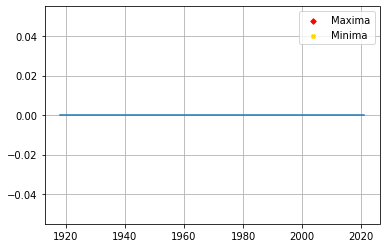

In [3]:
def PeakPoint(df_ls,mut_ls):
    DF = pd.DataFrame()
    for i, df in enumerate(df_ls):
        x=df.index.values
        y=df.change.values
        #Find peaks
        peaks = find_peaks(y, height = 0.05, threshold = 0.01, distance = 1)
        height = y[peaks[0]] #list of the heights of the peaks
        peak_pos = x[peaks[0]] #list of the peaks positions

        #Finding the minima
        y2 = y*-1
        minima = find_peaks(y2,height = 0.05, threshold = 0.01, distance = 1)
        min_pos = x[minima[0]] #list of the minima positions
        min_height = y2[minima[0]] #list of the mirrored minima heights
        year=np.concatenate((peak_pos,min_pos))
        val=np.concatenate((height,min_height*-1))
        df = pd.DataFrame()
        df['peak_year']=year
        df['peak_magnitude']=val
        df['resi']=mut_ls[i][:-1]
        df['aa']=mut_ls[i][-1]
        df.set_index("peak_year",inplace=True)
        # set the date columns as index
        df.sort_index(inplace=True)
        DF=DF.append(df)
    return DF
DF = PeakPoint(df_ls,mut_ls)
print(DF)
df = df_ls[0]
x=df.index.values
y=df.change.values

#Find peaks
peaks = find_peaks(y, height = 0.05, threshold = 0.01, distance = 1)
height = y[peaks[0]] #list of the heights of the peaks
peak_pos = x[peaks[0]] #list of the peaks positions

#Finding the minima
y2 = y*-1
minima = find_peaks(y2,height = 0.05, threshold = 0.01, distance = 1)
min_pos = x[minima[0]] #list of the minima positions
min_height = y2[minima[0]] #list of the mirrored minima heights
year=np.concatenate((peak_pos,min_pos))
val=np.concatenate((height,min_height*-1))
df = pd.DataFrame()
df['peak_year']=year
df['peak_magnitude']=val
df['resi']=mut_ls[0][:-1]
df['aa']=mut_ls[0][-1]

print(df)
#Plotting
fig = plt.figure()
ax = fig.subplots()
ax.plot(x,y)
ax.scatter(peak_pos, height, color = 'r', s = 15, marker = 'D', label = 'Maxima')
ax.scatter(min_pos, min_height*-1, color = 'gold', s = 15, marker = 'X', label = 'Minima')
ax.legend()
ax.grid()
plt.show()

In [7]:
#compare the peak distance(year) for different residues
resi=[328,329,341,364,365,366,367]
compare_ls=itertools.combinations(resi,2)
Compare_DF=pd.DataFrame(columns=["peak_1_year","peak_2_year","peak_1_magnitude","peak_2_magnitude","peak_1_resi","peak_2_resi","peak_1_aa","peak_2_aa","inter_peak_distance","inter_peak_class"])
for pair in compare_ls:
    i=pair[0]
    j=pair[1]
    i_df = DF[DF['resi']==str(i)]
    j_df = DF[DF['resi']==str(j)]
    for year_i, row_i in i_df.iterrows():
        peak_1_year=year_i
        peak_1_magnitude=row_i['peak_magnitude']
        peak_1_resi=row_i['resi']
        peak_1_aa=row_i['aa']
        peak_1='+'if peak_1_magnitude>0 else '-'
        for year_j, row_j in j_df.iterrows():
            peak_2_year=year_j
            peak_2_magnitude=row_j['peak_magnitude']
            peak_2_resi=row_j['resi']
            peak_2_aa=row_j['aa']
            peak_2='+'if peak_2_magnitude>0 else '-'
            inter_peak_distance=abs(peak_1_year-peak_2_year)
            inter_ppeak_class=peak_1+peak_2
            #add to dataframe
            add_row=[peak_1_year,peak_2_year,peak_1_magnitude,peak_2_magnitude,peak_1_resi,peak_2_resi,peak_1_aa,peak_2_aa,inter_peak_distance,inter_ppeak_class]
            add_series = pd.Series(add_row, index = Compare_DF.columns)
            Compare_DF = Compare_DF.append(add_series,ignore_index=True)
print(Compare_DF)
#Compare_DF.to_csv('../result/compare_peak.csv')

     peak_1_year peak_2_year  peak_1_magnitude  peak_2_magnitude peak_1_resi  \
0           1932        1932          1.000000         -1.000000         329   
1           1932        1976          1.000000          1.000000         329   
2           1932        1977          1.000000         -1.000000         329   
3           1932        1984          1.000000          0.480000         329   
4           1932        1986          1.000000         -0.500000         329   
...          ...         ...               ...               ...         ...   
3711        1936        1998         -0.333333          0.277778         365   
3712        1936        1999         -0.333333         -0.333333         365   
3713        1936        2009         -0.333333          0.684707         365   
3714        1936        2014         -0.333333         -0.112010         365   
3715        1936        2015         -0.333333          0.108181         365   

     peak_2_resi peak_1_aa peak_2_aa in

In [8]:
#filter out distance > 5 year
Compare_DF=Compare_DF[Compare_DF.inter_peak_distance <=5]
print(Compare_DF)

     peak_1_year peak_2_year  peak_1_magnitude  peak_2_magnitude peak_1_resi  \
0           1932        1932          1.000000         -1.000000         329   
15          1932        1932          1.000000          1.000000         329   
30          1933        1932         -0.416667         -1.000000         329   
45          1933        1932         -0.416667          1.000000         329   
60          1935        1932          0.447917         -1.000000         329   
...          ...         ...               ...               ...         ...   
3429        2014        2015          0.109528          0.108181         341   
3439        2015        2014         -0.092797          0.112010         341   
3440        2015        2015         -0.092797         -0.108181         341   
3450        2015        2014         -0.092797         -0.112010         341   
3451        2015        2015         -0.092797          0.108181         341   

     peak_2_resi peak_1_aa peak_2_aa in

In [9]:
pos_DF1=Compare_DF[Compare_DF['inter_peak_class']=='++']
pos_DF2=Compare_DF[Compare_DF['inter_peak_class']=='--']
pos_DF=pd.concat([pos_DF1,pos_DF2])
pos_DF.loc[:,'EPI_ID']=pos_DF['peak_1_aa']+pos_DF['peak_1_resi']+'/'+pos_DF['peak_2_aa']+pos_DF['peak_2_resi']
mut_id=list(set(pos_DF.EPI_ID))
epi_ls=[]
for x in mut_id:
    pos_DF_x = pos_DF[pos_DF.EPI_ID==x]
    pos_DF_x.loc[:,'exp_distance']=np.exp(-1*pos_DF_x['inter_peak_distance'].astype('float'))
    epi=pos_DF_x.exp_distance.sum()
    epi_ls.append(epi)
natural_df = pd.DataFrame({'pair':mut_id,'Coevol_S':epi_ls})
print(natural_df)

         pair   Coevol_S
0   n341/+366   4.203387
1   +329/-341  15.119009
2   -329/-365   0.735759
3   -341/-365   1.000000
4   -341/+365   0.049787
5   -329/+365   0.503215
6   n329/-365   0.135335
7   n341/+365   0.018316
8   -341/+366  10.886464
9   n329/n366  10.886464
10  -341/n365   0.153651
11  +329/n366   4.196649
12  n341/n365   1.049787
13  +329/+366  10.254344
14  -329/+366   1.000000
15  n341/-365   0.135335
16  n329/-341   5.081219
17  n329/+365   0.018316
18  +329/+365   1.099574
19  n329/n341  15.701342
20  n341/n366  10.886464
21  +329/n341   5.435623
22  -329/n365   1.467454
23  n329/+366   4.210125
24  -329/n341   0.431142
25  -341/n366   4.203387
26  -329/n366   0.381355
27  -329/-341   1.367879
28  n329/n365   1.049787
29  +329/-365   1.417667
30  +329/n365   1.392625


/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [10]:
neg_DF1=Compare_DF[(Compare_DF['inter_peak_class']=='-+')]
neg_DF2=Compare_DF[(Compare_DF['inter_peak_class']=='+-')]
neg_DF=pd.concat([neg_DF1,neg_DF2])
neg_DF.loc[:,'EPI_ID']=neg_DF['peak_1_aa']+neg_DF['peak_1_resi']+'/'+neg_DF['peak_2_aa']+neg_DF['peak_2_resi']
mut_id=list(set(neg_DF.EPI_ID))
epi_ls=[]
for x in mut_id:
    neg_DF_x = neg_DF[neg_DF.EPI_ID==x]
    neg_DF_x.loc[:,'exp_distance']=-1*np.exp(-1*neg_DF_x['inter_peak_distance'].astype('float'))
    epi=neg_DF_x.exp_distance.sum()
    epi_ls.append(epi)
natural_df2 = pd.DataFrame({'pair':mut_id,'Coevol_S':epi_ls})

natural_df = pd.concat([natural_df,natural_df2])
print(natural_df)
natural_df=natural_df.groupby('pair').sum()
print(natural_df)

         pair   Coevol_S
0   n341/+366   4.203387
1   +329/-341  15.119009
2   -329/-365   0.735759
3   -341/-365   1.000000
4   -341/+365   0.049787
..        ...        ...
26  -329/n366  -1.000000
27  -329/-341  -0.431142
28  n329/n365  -0.153651
29  +329/-365  -0.871094
30  +329/n365  -2.517241

[62 rows x 2 columns]
            Coevol_S
pair                
+329/+365   0.578044
+329/+366   6.057695
+329/-341   9.683386
+329/-365   0.546572
+329/n341  -9.683386
+329/n365  -1.124616
+329/n366  -6.057695
-329/+365  -0.546572
-329/+366   0.618645
-329/-341   0.936737
-329/-365   0.318092
-329/n341  -0.936737
-329/n365   0.228480
-329/n366  -0.618645
-341/+365   0.031471
-341/+366   6.683078
-341/-365   0.864665
-341/n365  -0.896136
-341/n366  -6.683078
n329/+365  -0.031471
n329/+366  -6.676340
n329/-341 -10.620123
n329/-365  -0.864665
n329/n341  10.620123
n329/n365   0.896136
n329/n366   6.676340
n341/+365  -0.031471
n341/+366  -6.683078
n341/-365  -0.864665
n341/n365   0.896136
n341/

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [11]:
natural_df.to_csv('../result/fluB/N108_Coevols_<5.csv')